# torch-autograd example

In this example we show how to train a model without torch nn layers.
We define an arbitrary function using `torch.` operators, which are automatically differentiated
into a neural network model. This is useful in case of complicated models, or 2-nd order derivatives needed.

In the end we will do t-SNE embedding of the learned features.

The notebook can run without GPU support and needs the following rocks:

```
luarocks install autograd
luarocks install mnist
luarocks install manifold
```

In [1]:
-- normally we would avoid having global variables
-- but local variables live only in one cell

grad = require 'autograd'       -- automatic differentiation 
mnist = require 'mnist'         -- MNIST dataset loader
manifold = require 'manifold'   -- for t-SNE embeddings
optim = require 'optim'

grad.optimize(true) -- will make autograd optimize graphs by default

In [2]:
-- define all parameters in this structure
opt = {
   learningRate = 1e-1,
   learningRateDecayRatio = 0.1,
   momentum = 0.9,
   weightDecay = 0.0005,
   dampening = 0,
   type = 'float',
   batchSize = 128,
}

## MLP model definition

In [3]:
-- define a simple NN layer W * x + b
function Linear(params, x)
   local W,b = params[1], params[2]
   local y = x * torch.transpose(W,1,2)
   return y + torch.expandAs(b:view(1,b:size(1)), y)
end

-- create parameter tensors and initialize with Xavier-init
function LinearParams(ni,no)
   local stdv = 1/math.sqrt(no); 
   return {torch.randn(no,ni):uniform(-stdv,stdv), torch.zeros(no)} 
end

-- cast function that supports float, double and cuda
cast = function(x) return grad.util.cast(x, opt.type); end

-- create a structure that holds all parameters
params = cast{
    LinearParams(28*28,512),
    LinearParams(512,64),
    LinearParams(64,10), 
}

-- define forward propagation function, that takes
-- * W - params structure like the one above
-- * x - input
-- It goes over params and computes a simple MLP with tanh
-- activation functions
f = function(W, x)
   local output = x:view(-1,28*28)
   for i,w in ipairs(W) do
      output = Linear(w, i == 1 and output or torch.tanh(output))
   end
   return output
end

-- define loss functions that in addition to params
-- and input takes targets tensor
h = function(W, x, y_hat)
   local y = f(W, x)
   return grad.loss.crossEntropy(y, y_hat) / y:size(1)
end

## Prepare data and show a few examples

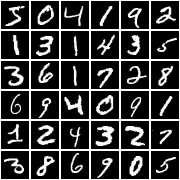

In [4]:
trainData = cast(mnist.traindataset())
testData = cast(mnist.testdataset())

-- simply normalize range to [0,1] range
trainData.label:add(1); trainData.data:div(256)
testData.label:add(1);  testData.data:div(256)

-- show a few examples from the training set
itorch.image(trainData.data:narrow(1,1,36))

## Training

Up to this point we haven't used any dedicated nn or autograd functions, only simple torch tensors operation.
We will now use $f$ and $h$ functions that we defined and will call autograd to do automatic differentiation to define train function, and will train the MLP on MNIST dataset

In [5]:
-- this function does all magic. It automatically differentiates $h$ and 
-- uses opt structure to construct structures that do SGD
-- returned $g$ is a function that calls SGD on one minibatch
-- that takes inputs $x$ and $y_hat$ targets 
local g = grad.optim.sgd(grad(h), grad.util.deepCopy(opt), params)

function train()
    local targets = cast(torch.Tensor(opt.batchSize,10))
    local inputs = cast(torch.Tensor(opt.batchSize,28*28))
    -- randomly permute the data
    local indices = torch.randperm(trainData.data:size(1)):long():split(opt.batchSize)
    indices[#indices] = nil -- avoid the last minibatch

    local loss = 0
    for t,v in ipairs(indices) do
        local inputs_ = trainData.data:index(1,v)
        local target_idx = trainData.label:index(1,v)
        targets:zero():scatter(2,target_idx:long():view(opt.batchSize,1),1)
        inputs:copy(inputs_)

        local grads,l = g(inputs, targets)
        loss = loss + l
    end
    return loss / #indices
end

function test()
    local confusion = optim.ConfusionMatrix(10)
    local inputs_split = testData.data:split(opt.batchSize)
    local targets_split = testData.label:split(opt.batchSize)
    
    for i,v in ipairs(inputs_split) do
        confusion:batchAdd(f(params, v), targets_split[i])
    end
    print(tostring(confusion))
    return confusion.totalValid
end

Alright, all the functions needed are defined! let's start training and plot the loss

In [6]:
local Plot = require 'itorch.Plot'

local nEpochs = 20

local losses = {}
for i=1,nEpochs do
    print('Epoch: '..i)
    table.insert(losses, train())
end

Plot():line(torch.range(1,#losses), torch.Tensor(losses)):draw()

Epoch: 1	


Epoch: 2	


Epoch: 3	


Epoch: 4	


Epoch: 5	


Epoch: 6	


Epoch: 7	


Epoch: 8	


Epoch: 9	


Epoch: 10	


Epoch: 11	


Epoch: 12	


Epoch: 13	


Epoch: 14	


Epoch: 15	


Epoch: 16	


Epoch: 17	


Epoch: 18	


Epoch: 19	


Epoch: 20	


In [7]:
-- print confusion matrix
test()

## Visualize t-SNE embedding of the learned features

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a (prize-winning) technique
for dimensionality reduction that is particularly well suited for the visualization
of high-dimensional datasets. The technique can be implemented via Barnes-Hut approximations,
allowing it to be applied on large real-world datasets.

For more information see https://lvdmaaten.github.io/tsne/

In [8]:
-- take a subset of MNIST test dataset
x_subset = testData.data:narrow(1,1,1000)

local W_t = grad.util.deepCopy(params)
W_t[#params] = nil -- remove the last layer

-- extract features
local features = f(W_t, x_subset)
print('extracted features size:', #features)

-- call t-SNE
p = manifold.embedding.tsne(features:double(), {dim=2, perplexity=30})

ConfusionMatrix:
[[     971       0       1       0       0       0       3       1       3       1]   99.082% 
 [       0    1123       3       1       0       1       3       1       3       0]   98.943% 
 [       4       1    1005       3       3       0       4       6       6       0]   97.384% 
 [       0       0       3     997       0       2       0       3       5       0]   98.713% 
 [       0       0       1       0     971       0       5       2       1       2]   98.880% 
 [       5       1       0       9       4     858       6       1       6       2]   96.188% 
 [       6       3       0       0       3       4     939       0       3       0]   98.017% 
 [       1       6      11       2       1       0       0    1003       2       2]   97.568% 
 [       4       0       2       5       1       1       3       2     955       1]   98.049% 
 [       4       5       0      12      28       1       0      14       7     938]]  92.963% 
 + average row correct: 97.578655

extracted features size:	 1000
   64
[torch.LongStorage of size 2]

Computing P-values...	


Running t-SNE...	


Iteration 10: KL divergence is 44.832246592819	


Iteration 20: KL divergence is 37.892226289938	


Iteration 30: KL divergence is 36.228972974459	


Iteration 40: KL divergence is 36.135559825456	


Iteration 50: KL divergence is 36.168377493549	


Iteration 60: KL divergence is 36.059750194989	


Iteration 70: KL divergence is 36.221346905569	


Iteration 80: KL divergence is 36.199052022455	


Iteration 90: KL divergence is 36.177214337047	


Iteration 100: KL divergence is 36.198799815465	


Iteration 110: KL divergence is 36.275038084313	


Iteration 120: KL divergence is 36.40139803708	


Iteration 130: KL divergence is 36.417330315211	


Iteration 140: KL divergence is 36.33617387188	


Iteration 150: KL divergence is 36.468170785624	


Iteration 160: KL divergence is 36.59012101625	


Iteration 170: KL divergence is 36.653457419649	


Iteration 180: KL divergence is 36.704379962344	


Iteration 190: KL divergence is 36.889479682786	


Iteration 200: KL divergence is 1.373272642535	


Iteration 210: KL divergence is 0.92240953400252	


Iteration 220: KL divergence is 0.68873145509082	


Iteration 230: KL divergence is 0.62434793633371	


Iteration 240: KL divergence is 0.59571542173665	


Iteration 250: KL divergence is 0.58293889121261	


Iteration 260: KL divergence is 0.5743162170098	


Iteration 270: KL divergence is 0.56730572485952	


Iteration 280: KL divergence is 0.56358339477389	


Iteration 290: KL divergence is 0.56319721618965	


Iteration 300: KL divergence is 0.56166916702289	


Iteration 310: KL divergence is 0.5598631917177	


Iteration 320: KL divergence is 0.55872810565076	


Iteration 330: KL divergence is 0.55802526356711	


Iteration 340: KL divergence is 0.5570389370636	


Iteration 350: KL divergence is 0.55558275749272	


Iteration 360: KL divergence is 0.55452855164404	


Iteration 370: KL divergence is 0.55411769127029	


Iteration 380: KL divergence is 0.55323243503148	


Iteration 390: KL divergence is 0.55242187666701	


Iteration 400: KL divergence is 0.55172825521442	


Iteration 410: KL divergence is 0.5509642322378	


Iteration 420: KL divergence is 0.54984678034629	


Iteration 430: KL divergence is 0.54921555963339	


Iteration 440: KL divergence is 0.54889042496932	


Iteration 450: KL divergence is 0.54826420030084	


Iteration 460: KL divergence is 0.54717133360816	


Iteration 470: KL divergence is 0.54629575129946	


Iteration 480: KL divergence is 0.54566296285421	


Iteration 490: KL divergence is 0.54507518071351	


Iteration 500: KL divergence is 0.54454016527357	


Iteration 510: KL divergence is 0.54410356420332	


Iteration 520: KL divergence is 0.54378856628179	


Iteration 530: KL divergence is 0.54354779235814	


Iteration 540: KL divergence is 0.5432343679296	


Iteration 550: KL divergence is 0.54299156952762	


Iteration 560: KL divergence is 0.54281569678148	


Iteration 570: KL divergence is 0.54251440171716	


Iteration 580: KL divergence is 0.54245152501447	


Iteration 590: KL divergence is 0.54226076960872	


Iteration 600: KL divergence is 0.54197757500354	


Iteration 610: KL divergence is 0.54142295960272	


Iteration 620: KL divergence is 0.54045132246731	


Iteration 630: KL divergence is 0.54009947996406	

Iteration 640: KL divergence is 0.53990240976834	


Iteration 650: KL divergence is 0.53970872062221	


Iteration 660: KL divergence is 0.53956414683302	


Iteration 670: KL divergence is 0.53925359384794	


Iteration 680: KL divergence is 0.53913597206362	


Iteration 690: KL divergence is 0.53900450710985	


Iteration 700: KL divergence is 0.53892780033619	


Iteration 710: KL divergence is 0.53879131015317	


Iteration 720: KL divergence is 0.53866379792385	


Iteration 730: KL divergence is 0.53857520561052	


Iteration 740: KL divergence is 0.53849441691551	


Iteration 750: KL divergence is 0.53841742362778	


Iteration 760: KL divergence is 0.53834240528086	


Iteration 770: KL divergence is 0.5382736379775	

Iteration 780: KL divergence is 0.53818641367611	


Iteration 790: KL divergence is 0.53807373867898	


Iteration 800: KL divergence is 0.53797382655477	


Iteration 810: KL divergence is 0.53787749048371	


Iteration 820: KL divergence is 0.53777649037375	


Iteration 830: KL divergence is 0.53769671290208	


Iteration 840: KL divergence is 0.53761931681676	


Iteration 850: KL divergence is 0.53756297245859	


Iteration 860: KL divergence is 0.53750581454043	


Iteration 870: KL divergence is 0.53744879422127	


Iteration 880: KL divergence is 0.53735823529746	


Iteration 890: KL divergence is 0.53726742171474	


Iteration 900: KL divergence is 0.53711245737398	


Iteration 910: KL divergence is 0.53701863633265	


Iteration 920: KL divergence is 0.53691653867263	


Iteration 930: KL divergence is 0.53682792041563	


Iteration 940: KL divergence is 0.53672063414213	


Iteration 950: KL divergence is 0.53664642031735	


Iteration 960: KL divergence is 0.53648353946723	


Iteration 970: KL divergence is 0.53624323906328	


Iteration 980: KL divergence is 0.53577900424047	


Iteration 990: KL divergence is 0.53518656944691	


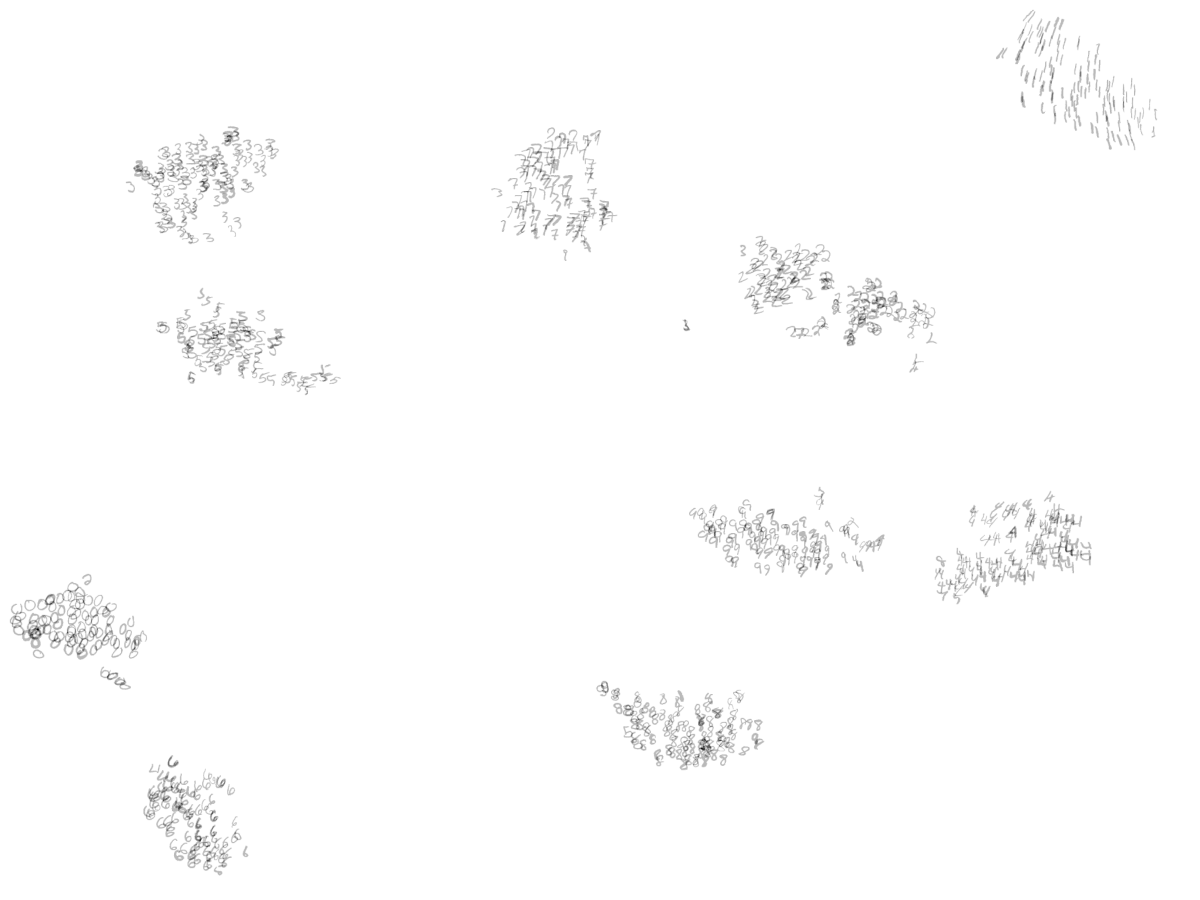

In [9]:
-- visualized computed embedding
local images = x_subset

local s = {900,1200}
local b = 16
local p_ = p:clone()
local px = p_:select(2,1)
local py = p_:select(2,2)
px = (px - px:min()) / (px:max() - px:min())
py = (py - py:min()) / (py:max() - py:min())
local im = torch.FloatTensor(1,s[1],s[2]):fill(0)
for i,v in ipairs(images:split(1)) do
    local x = math.ceil(b + px[i]*s[1]*0.95)
    local y = math.ceil(b + py[i]*s[2]*0.95)
    local scaled = image.scale(v,b,b)
    im[{{},{x-b/2,x+b/2-1},{y-b/2,y+b/2-1}}]:add(scaled)
end

-- and clusters of data we shall see:
itorch.image(-im+1)

# Homework

As a homework you can try the following:
 * Visualize t-SNE embedding over training, started from randomly initialized network
 * Try more complicated network structure, e.g. convolutional network, LeNet
 * Experiment with different optimization methods, try ADAM or L-BFGS
 * Try out another loss function

## More examples

For more examples on torch-autograd check these repositories:
* Original torch-autograd examples https://github.com/twitter/torch-autograd/tree/master/examples
* neural-style implemented in autograd https://github.com/szagoruyko/neural-style-autograd more natural implementation with ~100 less lines